In [1]:
from __future__ import print_function, division, absolute_import
import numpy as np
from scipy.optimize import fmin_l_bfgs_b, least_squares, fmin_slsqp, minimize
import pyfde
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import constrNMPy as cNM
from joblib import Parallel, delayed

sns.set()


def otto_model_create_data(x):
    """
    Run the otto model to generate numerical data
    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    f: frequencies of the data points

    example:
    zr, zj = otto_model_create_test_data(x)
    zr: 1D Numpy array of length f real component of z
    zj: 1D Numpy array of length f imaginary component of z
    """
    # parasitic capacitance values for wires
    wire1 = 1. / (( 1./ wire_r) + ((1j*2*np.pi*f) * wire_c1))
    wire2 = 1. / (( 1./ wire_r) + ((1j*2*np.pi*f) * wire_c2))
    
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = wire1 + ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex))) + wire2
    return np.real(ztot), np.abs(np.imag(ztot))


def otto_model_L1_log(x):
    """
    return the L1 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # parasitic capacitance values for wires
    wire1 = 1. / (( 1./ wire_r) + ((1j*2*np.pi*f) * wire_c1))
    wire2 = 1. / (( 1./ wire_r) + ((1j*2*np.pi*f) * wire_c2))

    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = wire1 + ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex))) + wire2
    er = np.log10(np.real(ztot))
    ej = np.log10(np.abs(np.imag(ztot)))
    L1 = (np.sum(np.abs(ir-er))/n) + (np.sum(np.abs(ij-ej))/n)
    if np.isnan(L1):
        return np.inf
    return L1


def otto_model_L2_log(x):
    """
    return the L2 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # parasitic capacitance values for wires
    wire1 = 1. / (( 1./ wire_r) + ((1j*2*np.pi*f) * wire_c1))
    wire2 = 1. / (( 1./ wire_r) + ((1j*2*np.pi*f) * wire_c2))

    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = wire1 + ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex))) + wire2
    er = np.log10(np.real(ztot))
    ej = np.log10(np.abs(np.imag(ztot)))
    e = np.concatenate((ir - er, ij - ej))
    L2 = np.dot(e.T, e)/n
    if np.isnan(L2):
        return np.inf
    return np.sqrt(L2)


def otto_model_L_inf(x):
    """
    return the L infity norm of the otto model for x from some test data
    this returns the maximum deviation in the real + max deviation imaginary

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # parasitic capacitance values for wires
    wire1 = 1. / (( 1./ wire_r) + ((1j*2*np.pi*f) * wire_c1))
    wire2 = 1. / (( 1./ wire_r) + ((1j*2*np.pi*f) * wire_c2))

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = wire1 + ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex))) + wire2

    L_inf = (np.max(np.abs(zr-np.real(ztot)))) +\
            (np.max(np.abs(zj-np.abs(np.imag(ztot)))))
    return L_inf


def otto_model_L2_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # parasitic capacitance values for wires
    wire1 = 1. / (( 1./ wire_r) + ((1j*2*np.pi*f) * wire_c1))
    wire2 = 1. / (( 1./ wire_r) + ((1j*2*np.pi*f) * wire_c2))

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    ztot = wire1 + ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex))) + wire2
    e = (((zr-np.real(ztot))**2)/(np.abs(zmag))) + \
        (((zj-np.abs(np.imag(ztot)))**2)/(np.abs(zmag)))
    L2 = np.dot(e.T, e)
    if np.isnan(L2):
        return np.inf
    return L2


def otto_model_L1_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # parasitic capacitance values for wires
    wire1 = 1. / (( 1./ wire_r) + ((1j*2*np.pi*f) * wire_c1))
    wire2 = 1. / (( 1./ wire_r) + ((1j*2*np.pi*f) * wire_c2))

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    ztot = wire1 + ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex))) + wire2

    e = np.sum((np.abs((zr-np.real(ztot))))/(np.abs(zmag))) + \
        np.sum((np.abs((zj-np.abs(np.imag(ztot)))))/(np.abs(zmag)))

    L1 = e / n
    if np.isnan(L1):
        return np.inf
    return L1


def plot_results(f, x_l1, x_l2, x_linf, x_k, title):
    """
    plots the results of all of the optimizations

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # plot the fitted data
    zr_l1, zj_l1 = otto_model_create_data(x_l1)
    zr_l2, zj_l2 = otto_model_create_data(x_l2)
    zr_linf, zj_linf = otto_model_create_data(x_linf)
    zr_lk, zj_lk = otto_model_create_data(x_k)

    plt.figure()
    plt.title(title)
    plt.plot(zr_l1, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(zr_l2, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(zr_linf, zj_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(zr_lk, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(zr, zj, 'xk', label='Test Data')
    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'rj_nolog.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(zr_l1, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(zr_l2, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(zr_linf, zj_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(zr_lk, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(zr, zj, 'xk', label='Test Data')
    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'rj.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(f, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(f, zj_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(f, zj, 'xk', label='Test Data')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'j.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zr_l1, 'o-', label='Log10 L1 norm')
    plt.plot(f, zr_l2, 's-', label='Log10 L2 norm')
    plt.plot(f, zr_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, zr_lk, '<-', label="Kaitlynn's norm")
    plt.plot(f, zr, 'xk', label='Test Data')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$Z_r (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'r.png', dpi=300, bbox_inches='tight')
    
    # residual plots
    plt.figure()
    plt.title(title)
    plt.plot(f, (zj-zj_l1)/zj, 'o-', label='Log10 L1 norm')
    plt.plot(f, (zj-zj_l2)/zj, 's-', label='Log10 L2 norm')
    plt.plot(f, (zj-zj_linf)/zj, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, (zj-zj_lk)/zj, '<-', label="Kaitlynn's norm")
    plt.plot([f[0], f[-1]], [0.0, 0.0], '-k')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$(Z_{j,\mathrm{data}} - Z_{j,\mathrm{model}})/Z_{j,\mathrm{data}}$')
    plt.xscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'j_resid.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, (zr-zr_l1)/zr, 'o-', label='Log10 L1 norm')
    plt.plot(f, (zr-zr_l2)/zr, 's-', label='Log10 L2 norm')
    plt.plot(f, (zr-zr_linf)/zr, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, (zr-zr_lk)/zr, '<-', label="Kaitlynn's norm")
    plt.plot([f[0], f[-1]], [0.0, 0.0], '-k')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$(Z_{r,\mathrm{data}} - Z_{r,\mathrm{model}})/Z_{r,\mathrm{data}}$')
    plt.xscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'r_resid.png', dpi=300, bbox_inches='tight')
    plt.show()


def my_opt_fun(obj_function):
    # run differential evolution
    solver = pyfde.ClassicDE(obj_function, n_dim=5, n_pop=50,
                             limits=bounds, minimize=True)
#     solver = pyfde.JADE(obj_function, n_dim=5, n_pop=50,
#                         limits=bounds, minimize=True)
#     solver.c = np.random.random()
#     solver.p = np.random.random()
    solver.cr = np.random.random()
    solver.f = np.random.random()
    # solver.cr, solver.f = 1.0, 0.9
    best, fit = solver.run(n_it=1000)
    fit = fit*-1
    # polish with constrained nelder mead simplex optimization
    res_cnm = cNM.constrNM(obj_function, best, bounds[:, 0], bounds[:, 1],
                           full_output=True, xtol=1e-15, ftol=1e-15)
    # if polish better save polish results
    if res_cnm['fopt'] < fit:
        opts = res_cnm['fopt']
        results_x = res_cnm['xopt']
        # print('Polish was better')
    else:
        opts = fit
        results_x = best
        # print('Polish did not help')
    return np.append(results_x, opts)


def opt_routine(obj_function, runs=50, n_proc=8):
    """
    An optimization routine which first runs a Differential Evolution
    (global optimization), then runs a Bounded BFGS (gradient optimization)
    to polish the result. This processes is repeated for a user defined number
    of runs (which default to 10).

    Input:
    obj_function - Your objective function to minimize
    runs (int: optional) - the number  of times to repeat the optimization
                            process (defaults runs=10)

    Output: results_x, opts, best_x, best_opt
    results_x - a 2D array of all x values from all optimization runs
    opts - a 1D array of the objective values from all optimization runs
    best_x - a 1D array of the best x values found
    best_opt - the best objective value
    """

    # initialize result arrays
    results_x = np.zeros((runs, 5))
    opts = np.zeros(runs)
    t0 = time()
    opt_res = Parallel(n_jobs=n_proc)(delayed(my_opt_fun)(obj_function) for _ in range(runs))  # noqa
    opt_res = np.array(opt_res)
    results_x = opt_res[:, :5]
    opts = opt_res[:, 5]
    t1 = time()
    print('Optimization runtime %0.4f seconds' % (t1-t0))
    # find the best result
    best_index = np.nanargmin(opts)
    best_opt = opts[best_index]
    best_x = results_x[best_index]
#     print('Paramters:', results_x)
#     print('Set of optima:', opts)
    print('Best Objective value:', best_opt)
    print('Best Paramters:', best_x, '\n')
    print('\n')
    return results_x, opts, best_x, best_opt


# Parasitic Capacitance Values for Wires
wire_r = 50.2
wire_c1 = 5.03e-9
wire_c2 = 9e-13


# Optimization on artifical solution
Run the optimization on known paramter values

Optimization runtime 95.5081 seconds
Best Objective value: 2.209191585222925e-11
Best Paramters: [6.80000000e-01 8.80000000e+00 3.40000000e+01 5.16440673e+27
 8.90002692e+01] 



Optimization runtime 81.6847 seconds
Best Objective value: 8.154798376863664e-11
Best Paramters: [6.80000000e-01 8.80000000e+00 3.40000000e+01 7.69758080e+29
 8.90001277e+01] 



Optimization runtime 81.6521 seconds
Best Objective value: 7.363809104924891e-14
Best Paramters: [6.80000000e-01 8.80000000e+00 3.40000000e+01 7.29019908e+29
 8.90002876e+01] 



Optimization runtime 75.0633 seconds
Best Objective value: 6.497574252782464e-39
Best Paramters: [6.80000000e-01 8.80000000e+00 3.40000000e+01 3.16699371e+29
 8.90001881e+01] 





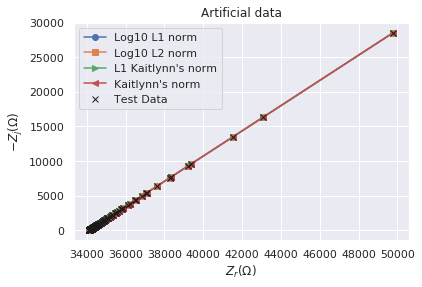

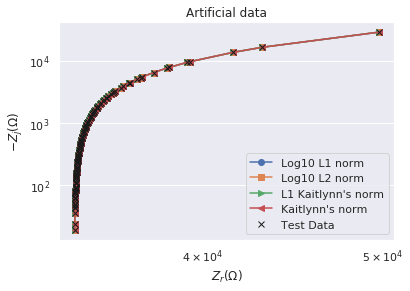

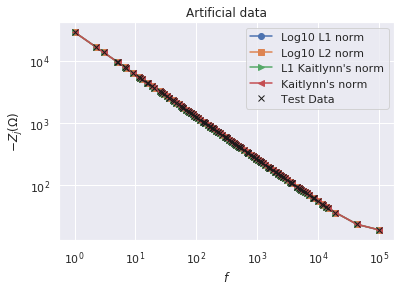

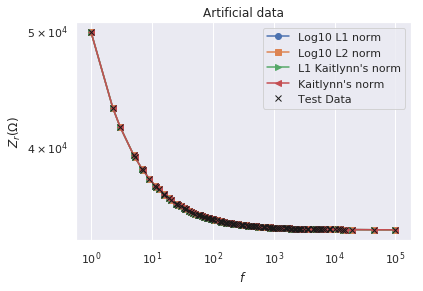

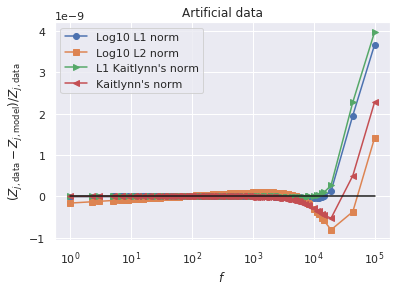

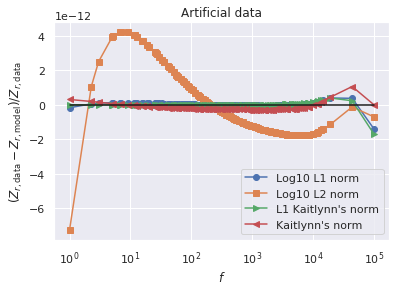

In [2]:
# optimization bounds
bounds = np.ones((5, 2))*1e-4
bounds[:, 1] = 1000.0
bounds[3, 1] = 1e30
bounds[2, 0] = 1e-2
bounds[4, 0] = 1e-10
bounds[0, 1] = 10.0

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

dataset = pd.read_csv(data_prefix+data_list[0])
f = dataset.values[:, 0]
# sort the f values
f_ind = np.argsort(f)
f = f[f_ind]
n = len(f)


# generate fake results
zr, zj = otto_model_create_data([0.68, 8.8, 34.0, 45.0, 89.0])

# remove nans in zr and zj experimental data
inds = np.where(np.isnan(np.log10(zj)))
zj = np.delete(zj, inds)
zr = np.delete(zr, inds)
f = np.delete(f, inds)
n = len(f)

# run log10 optimizations
xs_l1, opts_l1, x_l1, opt_l1 = opt_routine(otto_model_L1_log)
xs_l2, opts_l2, x_l2, opt_l2 = opt_routine(otto_model_L2_log)

# run normal optimizations
xs_lk1, opts_lk1, x_lk1, opt_lk1 = opt_routine(otto_model_L1_Kait)
xs_lk2, opts_lk2, x_lk2, opt_lk2 = opt_routine(otto_model_L2_Kait)

plot_results(f, x_l1, x_l2, x_lk1, x_lk2,
     'Artificial data')

# Run optimization on Blue Test Data

Optimization runtime 85.7233 seconds
Best Objective value: 0.018345905561219216
Best Paramters: [3.96615848e-01 6.32998087e-01 1.61496492e+00 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 79.1197 seconds
Best Objective value: 0.0272662808852353
Best Paramters: [4.04316503e-01 6.07212519e-01 2.56996884e+00 1.00000000e-04
 1.00501072e-10] 



Optimization runtime 88.0091 seconds
Best Objective value: 0.028418735528154195
Best Paramters: [3.95823186e-01 6.36240352e-01 1.53481327e+00 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 78.9571 seconds
Best Objective value: 1214854982.4659557
Best Paramters: [4.75516533e-01 4.93266756e-01 1.96642841e+00 2.78416312e+29
 4.52189536e-04] 





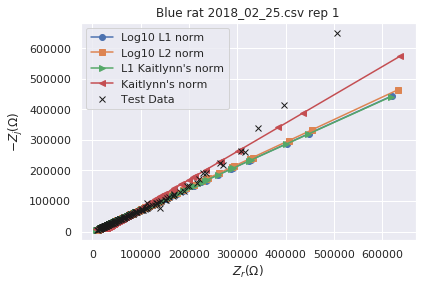

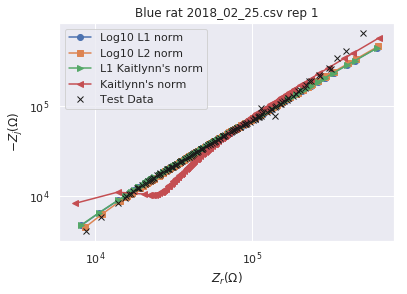

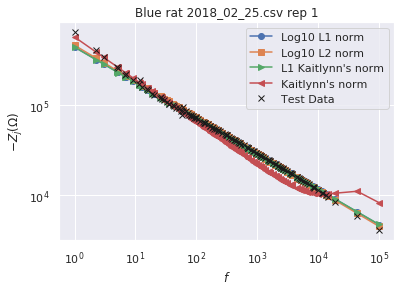

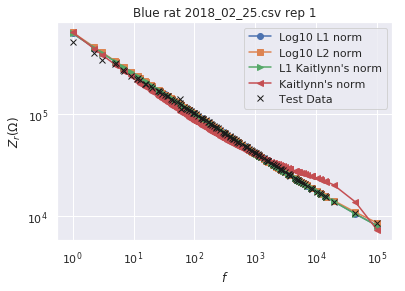

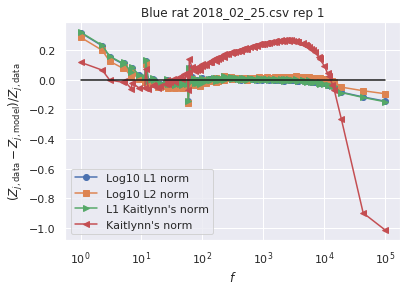

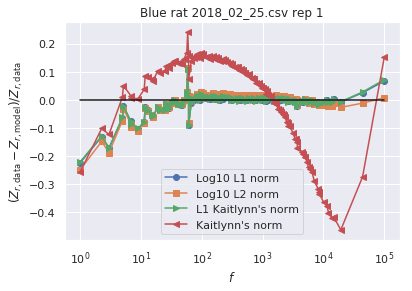

Optimization runtime 87.3186 seconds
Best Objective value: 0.01679020520887995
Best Paramters: [3.92054228e-01 6.38047371e-01 1.91778068e+00 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 76.0648 seconds
Best Objective value: 0.02952308715551048
Best Paramters: [4.00002056e-01 6.10435121e-01 2.72018530e+00 4.98781140e+29
 3.82240476e-02] 



Optimization runtime 80.6113 seconds
Best Objective value: 0.02586807885261844
Best Paramters: [3.91129478e-01 6.42553997e-01 1.84151912e+00 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 71.1658 seconds
Best Objective value: 2286669706.498607
Best Paramters: [4.89459924e-01 4.69243548e-01 1.50535591e+00 7.44182383e+29
 3.54278357e-04] 





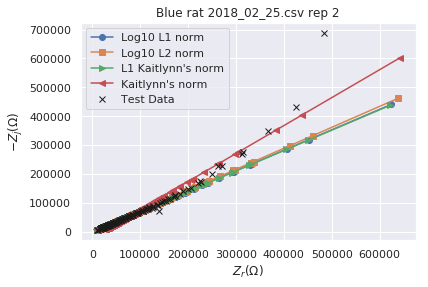

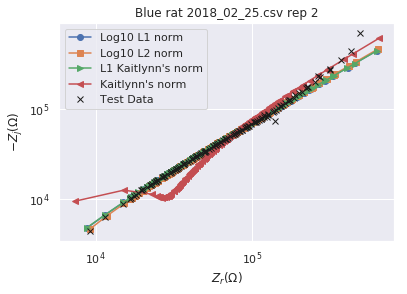

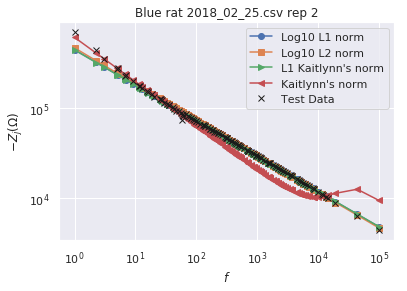

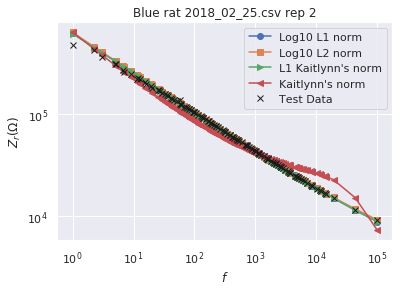

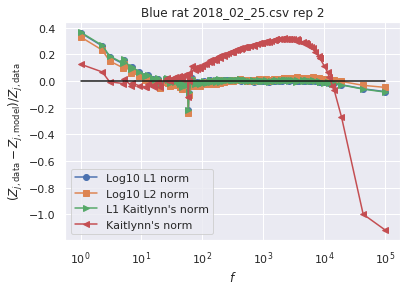

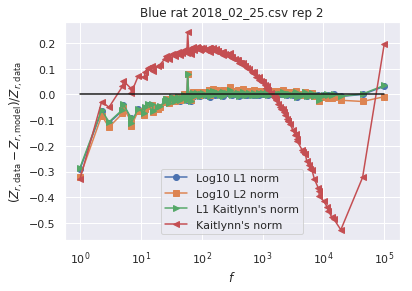

Optimization runtime 99.9054 seconds
Best Objective value: 0.06997143779347256
Best Paramters: [4.33003742e-01 5.51412141e-01 1.30145762e+01 1.00000000e+30
 1.28159172e-03] 



Optimization runtime 92.4180 seconds
Best Objective value: 0.11364971415019998
Best Paramters: [4.82229793e-01 3.91945412e-01 1.21831900e+01 5.14018171e+29
 6.37509355e-04] 



Optimization runtime 87.4869 seconds
Best Objective value: 0.08923436409863222
Best Paramters: [4.27023449e-01 5.75185332e-01 1.34131117e+01 1.00000000e+30
 1.53753640e-03] 



Optimization runtime 83.7766 seconds
Best Objective value: 757295471558.2085
Best Paramters: [5.29345806e-01 2.94483960e-01 1.03472713e+01 1.00000000e+30
 2.62570678e-04] 





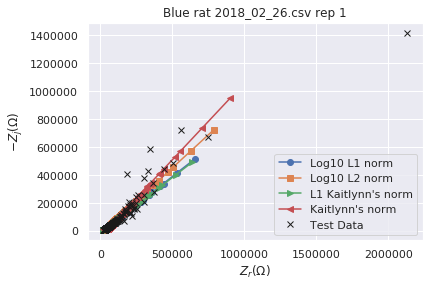

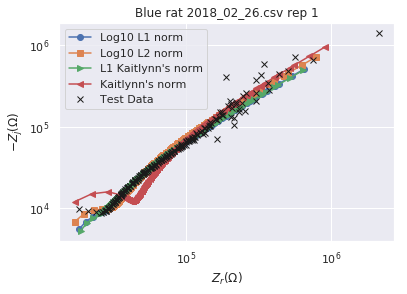

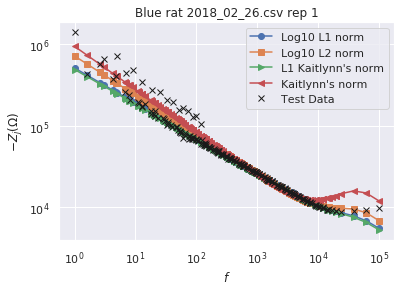

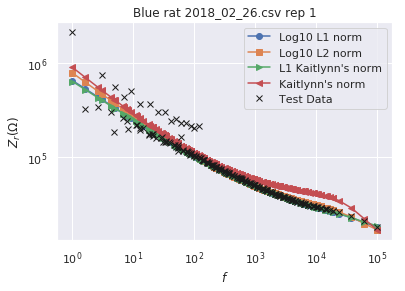

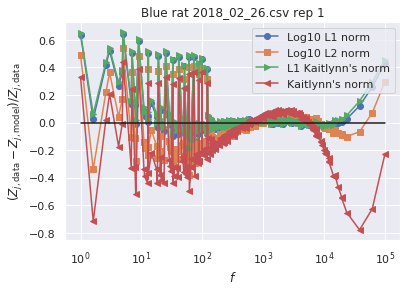

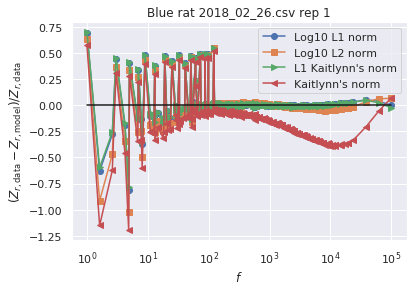

Optimization runtime 96.6840 seconds
Best Objective value: 0.06997143779347258
Best Paramters: [4.33003742e-01 5.51412141e-01 1.30145762e+01 9.14886241e+29
 1.28159172e-03] 



Optimization runtime 92.8712 seconds
Best Objective value: 0.11364971415019999
Best Paramters: [4.82229792e-01 3.91945412e-01 1.21831899e+01 1.00000000e+30
 6.37509358e-04] 



Optimization runtime 90.4490 seconds
Best Objective value: 0.08923436409863221
Best Paramters: [4.27023449e-01 5.75185332e-01 1.34131117e+01 3.18153686e+29
 1.53753640e-03] 



Optimization runtime 82.3768 seconds
Best Objective value: 757295471558.2085
Best Paramters: [5.29345804e-01 2.94483962e-01 1.03472518e+01 4.02253815e+29
 2.62570467e-04] 





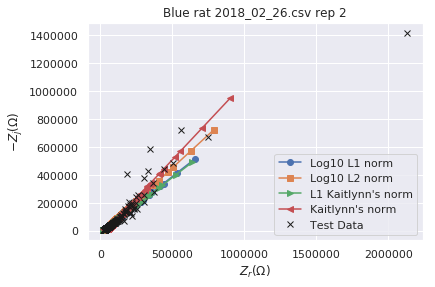

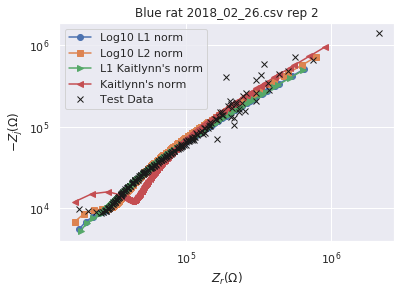

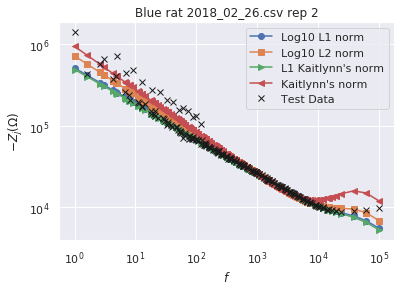

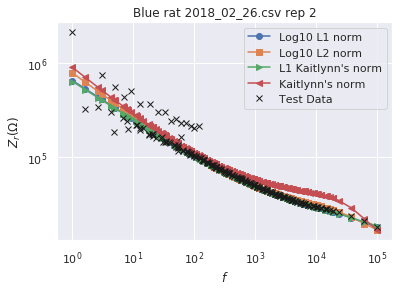

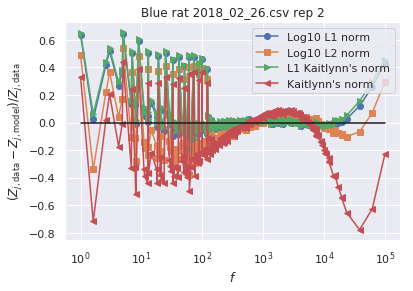

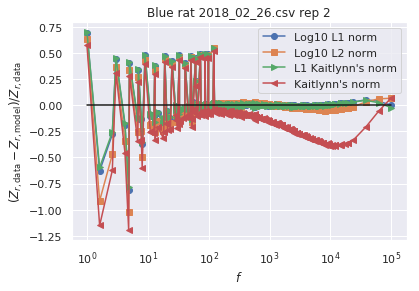

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log10


Optimization runtime 99.2129 seconds
Best Objective value: 0.17725404385494575
Best Paramters: [6.90863987e-01 8.79150011e-03 1.00000000e-02 1.00000000e+30
 1.14673847e-04] 



Optimization runtime 91.1316 seconds
Best Objective value: 0.2206944471856408
Best Paramters: [5.84866808e-01 1.95319915e-02 1.00000000e-02 1.00000000e+30
 2.93516381e-04] 



Optimization runtime 90.0592 seconds
Best Objective value: 0.31893174557356646
Best Paramters: [6.13964687e-01 1.64825564e-02 1.00000000e-02 3.15048226e+29
 1.82518782e-04] 



Optimization runtime 84.7325 seconds
Best Objective value: 107054433005011.55
Best Paramters: [3.47958092e-01 8.67317406e-02 1.00000000e-02 1.00000000e-04
 1.00000000e+03] 





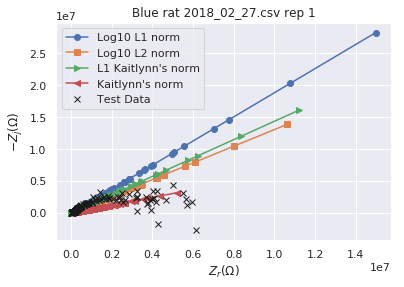

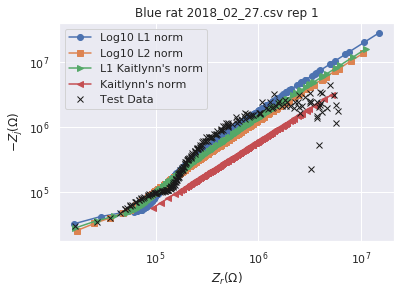

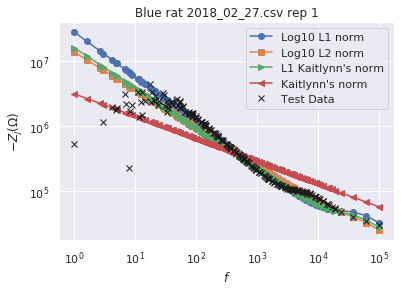

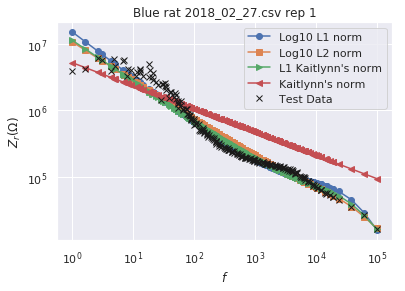

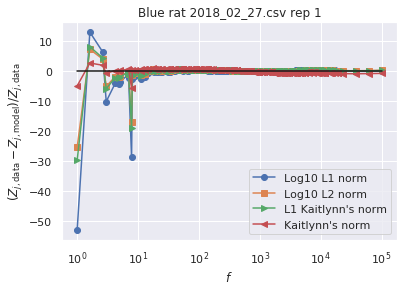

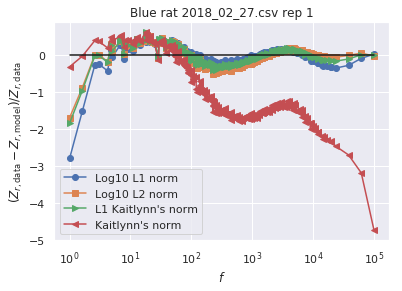

Optimization runtime 98.6115 seconds
Best Objective value: 0.18710301963683063
Best Paramters: [7.02395988e-01 8.01608827e-03 1.00000000e-02 4.46406521e+28
 1.05358818e-04] 



Optimization runtime 91.1170 seconds
Best Objective value: 0.2409785451509496
Best Paramters: [5.63280183e-01 2.26740121e-02 1.00000000e-02 1.00000000e+30
 4.61635744e-04] 



Optimization runtime 91.2789 seconds
Best Objective value: 0.31808194146352675
Best Paramters: [6.30653808e-01 1.41623814e-02 1.00000000e-02 3.23058861e+29
 1.63746997e-04] 



Optimization runtime 83.5346 seconds
Best Objective value: 155760717058056.22
Best Paramters: [3.63907541e-01 6.95114932e-02 1.00000000e-02 1.00000000e-04
 1.00000000e+03] 





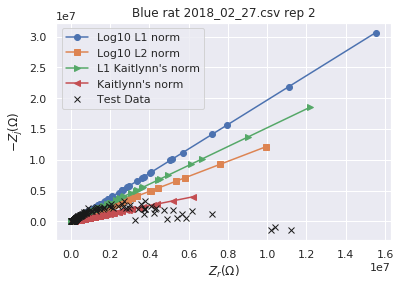

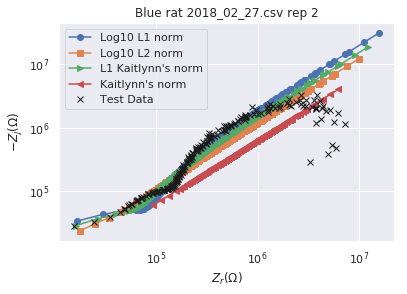

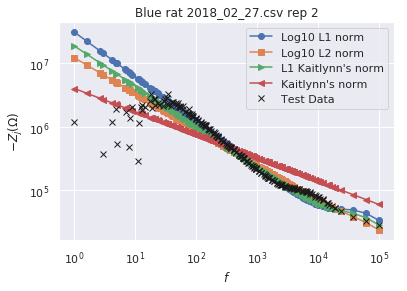

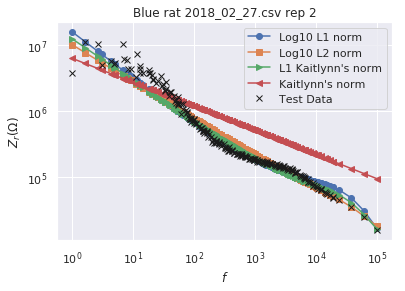

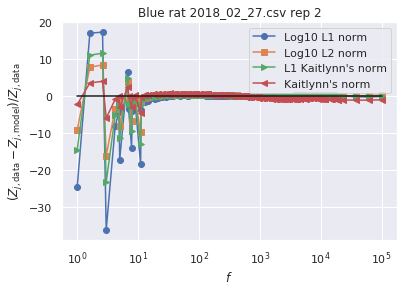

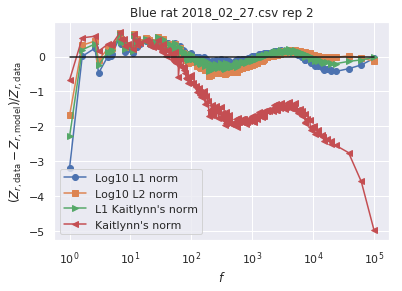

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in log10


Optimization runtime 93.2448 seconds
Best Objective value: 0.16762703585145106
Best Paramters: [7.07649279e-01 6.71622062e-03 1.00000000e-02 1.00000000e+30
 2.99163915e-04] 



Optimization runtime 85.4280 seconds
Best Objective value: 0.24348779972079587
Best Paramters: [7.37310794e-01 5.65787172e-03 1.00000000e-02 1.00000000e+30
 2.33873851e-04] 



Optimization runtime 89.3011 seconds
Best Objective value: 0.7564814585127775
Best Paramters: [5.10241844e-01 4.96285070e-02 1.00000000e-02 1.00000000e-04
 1.00000000e+03] 



Optimization runtime 84.2803 seconds
Best Objective value: 2115058486221115.8
Best Paramters: [3.58654210e-01 5.87792467e-01 1.00000000e-02 1.00000000e-04
 1.00000000e+03] 





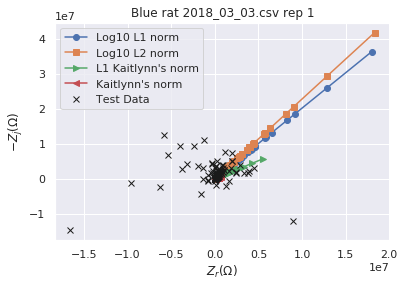

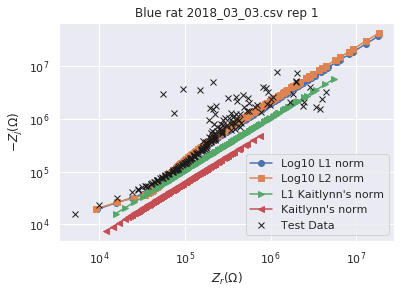

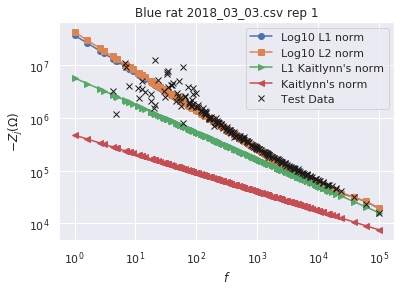

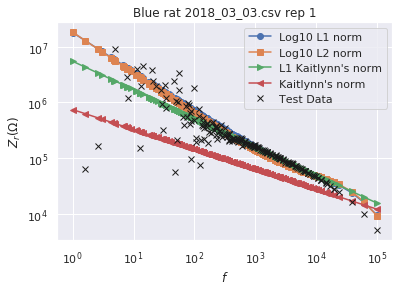

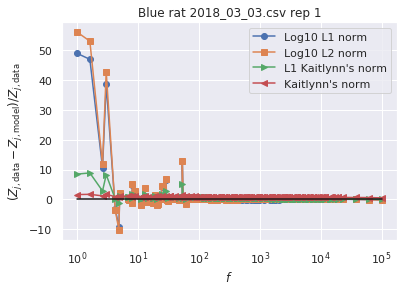

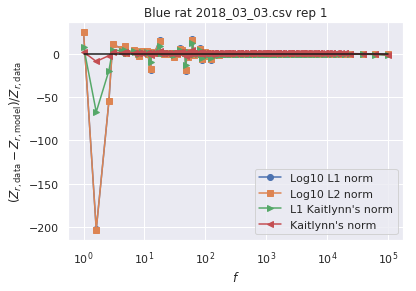

Optimization runtime 93.9826 seconds
Best Objective value: 0.1701871730011103
Best Paramters: [7.03551754e-01 6.94851986e-03 1.00000000e-02 1.00000000e+30
 2.89003799e-04] 



Optimization runtime 88.1453 seconds
Best Objective value: 0.21232352232194274
Best Paramters: [7.15553008e-01 6.33443261e-03 1.00000000e-02 2.43616642e+29
 3.03164959e-04] 



Optimization runtime 89.5853 seconds
Best Objective value: 0.648208001425974
Best Paramters: [5.60795944e-01 2.72740688e-02 1.00000000e-02 1.00000000e-04
 1.00000000e+03] 



Optimization runtime 83.0726 seconds
Best Objective value: 1464283067059117.5
Best Paramters: [2.66859634e-01 3.43784548e-01 1.00000000e-02 1.00000000e-04
 1.00000000e+03] 





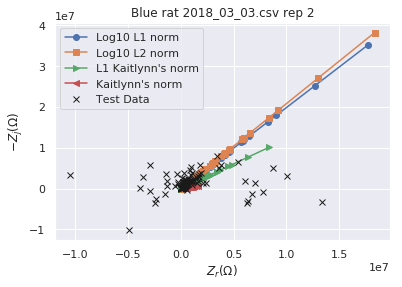

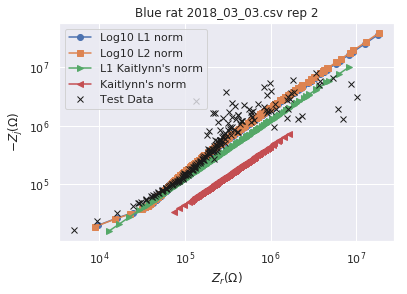

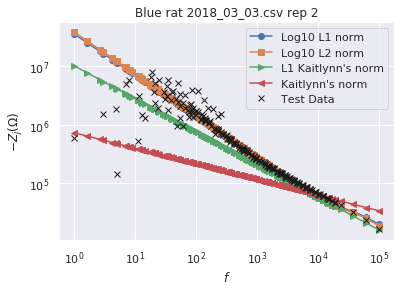

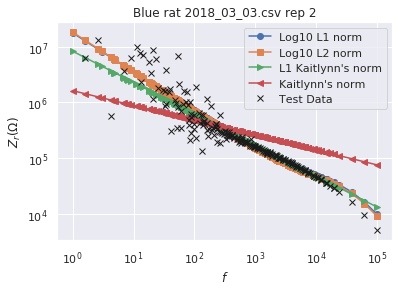

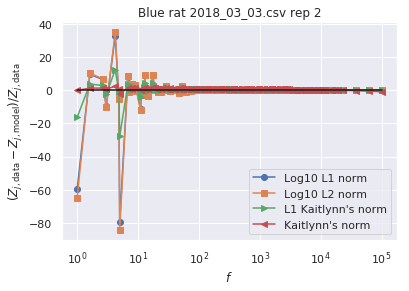

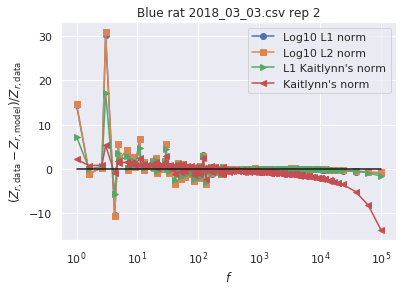

Optimization runtime 92.5029 seconds
Best Objective value: 0.09458047649841356
Best Paramters: [4.94892696e-01 4.52512565e-02 1.00000000e-02 1.00000000e+30
 7.59193051e-04] 



Optimization runtime 86.6049 seconds
Best Objective value: 0.11796310920616593
Best Paramters: [5.12503974e-01 3.73335646e-02 1.00000000e-02 7.18895675e+29
 1.00000000e+03] 



Optimization runtime 86.9616 seconds
Best Objective value: 0.14593920119165618
Best Paramters: [4.92460119e-01 4.62083597e-02 1.00000000e-02 7.84133994e+29
 1.04391035e-03] 



Optimization runtime 80.2261 seconds
Best Objective value: 143773946851.125
Best Paramters: [5.43012514e-01 2.90151086e-02 1.00000000e-02 7.26745020e+29
 8.86892073e-04] 





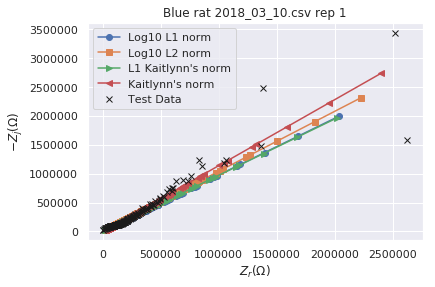

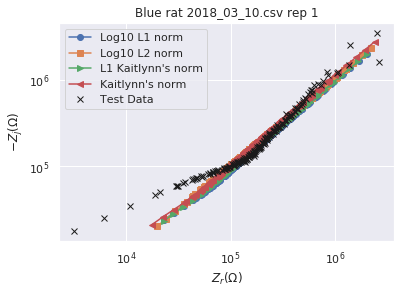

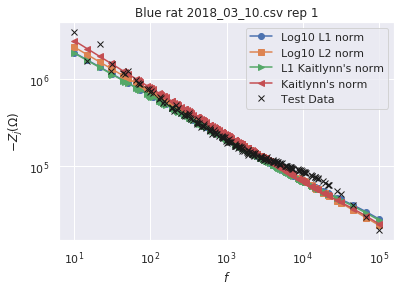

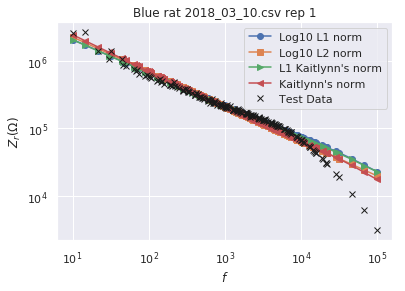

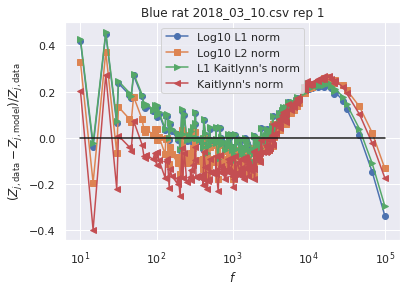

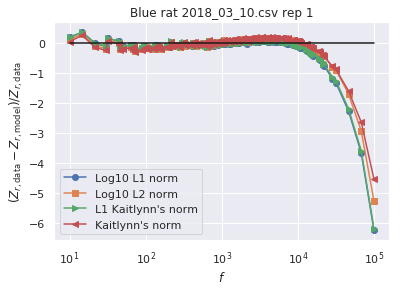

Optimization runtime 94.9569 seconds
Best Objective value: 0.10455832208585095
Best Paramters: [4.93079706e-01 4.67232011e-02 1.00000000e-02 1.00000000e+30
 6.26788457e-04] 



Optimization runtime 85.1141 seconds
Best Objective value: 0.12343502415978015
Best Paramters: [5.07192516e-01 3.95907039e-02 1.00000000e-02 1.00000000e+30
 1.80746428e-02] 



Optimization runtime 86.3828 seconds
Best Objective value: 0.1612356770999659
Best Paramters: [5.00801319e-01 4.45587605e-02 1.00000000e-02 3.89086403e+29
 5.18222280e-04] 



Optimization runtime 79.8217 seconds
Best Objective value: 362122736041.567
Best Paramters: [4.95728858e-01 3.90732616e-02 1.00000000e-02 1.00000000e-04
 1.00000000e+03] 





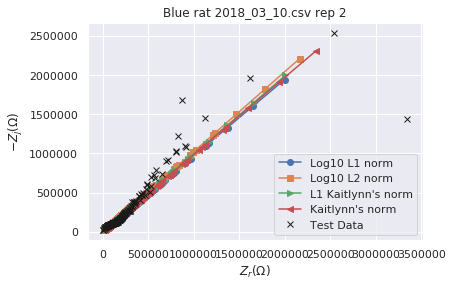

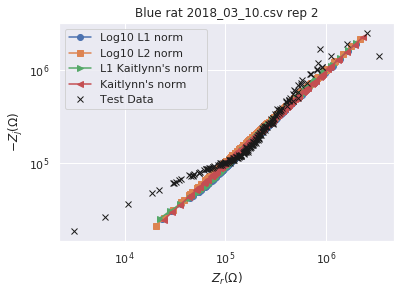

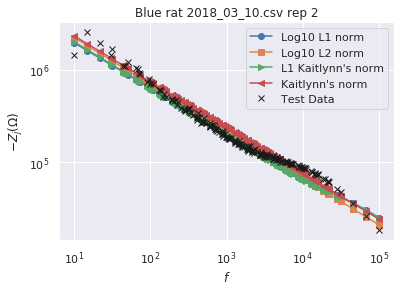

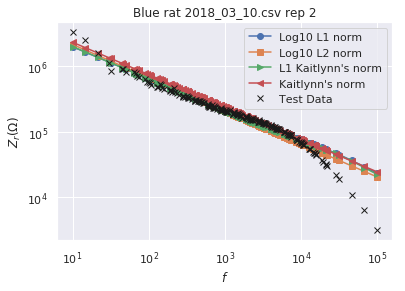

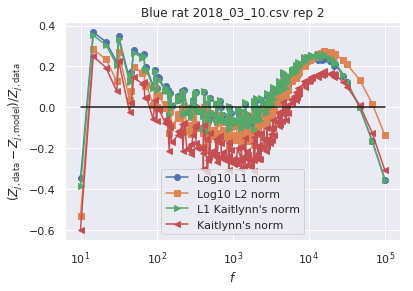

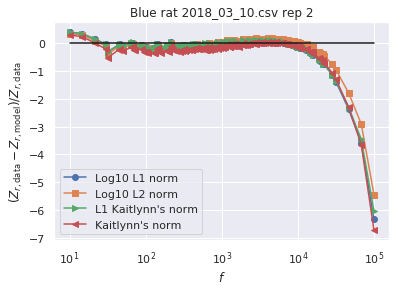

Stored 'res_l1' (ndarray)
Stored 'res_l2' (ndarray)
Stored 'res_lk1' (ndarray)
Stored 'res_lk2' (ndarray)
Stored 'l1_params' (list)
Stored 'l1_opts' (list)
Stored 'l2_params' (list)
Stored 'l2_opts' (list)
Stored 'lk1_params' (list)
Stored 'lk1_opts' (list)
Stored 'lk2_params' (list)
Stored 'lk2_opts' (list)


In [3]:
# optimization bounds
bounds = np.ones((5, 2))*1e-4
bounds[:, 1] = 1000.0
bounds[3, 1] = 1e30
bounds[2, 0] = 1e-2
bounds[4, 0] = 1e-10
bounds[0, 1] = 10.0

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

res_l1 = np.zeros((10, 6))
res_l2 = np.zeros((10, 6))
res_lk1 = np.zeros((10, 6))
res_lk2 = np.zeros((10, 6))

l1_params = []
l1_opts = []
l2_params = []
l2_opts = []
lk1_params = []
lk1_opts = []
lk2_params = []
lk2_opts = []

for ind, data in enumerate(data_list):
    dataset = pd.read_csv(data_prefix+data)
    for i in range(2):
        j = i*3
        f = dataset.values[:, j]
        n = len(f)
        zr = dataset.values[:, j+1]
        zj = dataset.values[:, j+2]
        
        # sort the zr zj and f values
        f_ind = np.argsort(f)
        f = f[f_ind]
        zr = zr[f_ind]
        zj = zj[f_ind]

        # remove nans in zr and zj experimental data
        inds = np.where(np.isnan(np.log10(zj)))
        zj = np.delete(zj, inds)
        zr = np.delete(zr, inds)
        f = np.delete(f, inds)
        inds = np.where(np.isnan(np.log10(zr)))
        zj = np.delete(zj, inds)
        zr = np.delete(zr, inds)
        f = np.delete(f, inds)
        n = len(f)

        # run log10 optimizations
        xs_l1, opts_l1, x_l1, opt_l1 = opt_routine(otto_model_L1_log)
        xs_l2, opts_l2, x_l2, opt_l2 = opt_routine(otto_model_L2_log)

        # reset data values
        f = dataset.values[:, j]
        n = len(f)
        zr = dataset.values[:, j+1]
        zj = dataset.values[:, j+2]

        # sort the zr zj and f values
        f_ind = np.argsort(f)
        f = f[f_ind]
        zr = zr[f_ind]
        zj = zj[f_ind]

        # run normal optimizations
        xs_lk1, opts_lk1, x_lk1, opt_lk1 = opt_routine(otto_model_L1_Kait)
        xs_lk2, opts_lk2, x_lk2, opt_lk2 = opt_routine(otto_model_L2_Kait)

        # # save the results into the array
        res_l1[ind*2 + i, :5] = x_l1
        res_l1[ind*2 + i, 5] = opt_l1
        res_l2[ind*2 + i, :5] = x_l2
        res_l2[ind*2 + i, 5] = opt_l2
        res_lk1[ind*2 + i, :5] = x_lk1
        res_lk1[ind*2 + i, 5] = opt_lk1
        res_lk2[ind*2 + i, :5] = x_lk2
        res_lk2[ind*2 + i, 5] = opt_lk2
        
        # append results
        l1_params.append(xs_l1)
        l1_opts.append(opts_l1)
        l2_params.append(xs_l2)
        l2_opts.append(opts_l2)
        lk1_params.append(xs_lk1)
        lk1_opts.append(opts_lk1)
        lk2_params.append(xs_lk2)
        lk2_opts.append(opts_lk2)
        
        plot_results(f, x_l1, x_l2, x_lk1, x_lk2,
             'Blue rat ' + data + ' rep ' + str(i+1))

%store res_l1
%store res_l2
%store res_lk1
%store res_lk2
%store l1_params
%store l1_opts
%store l2_params
%store l2_opts
%store lk1_params
%store lk1_opts
%store lk2_params
%store lk2_opts

# Example results for just one curve

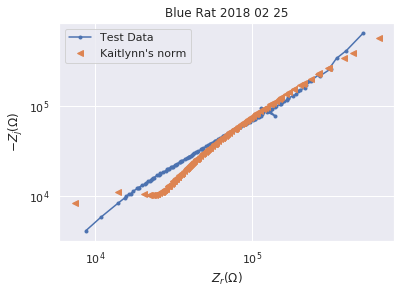

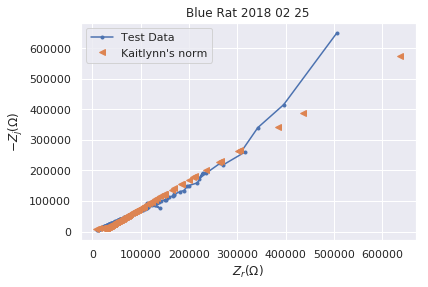

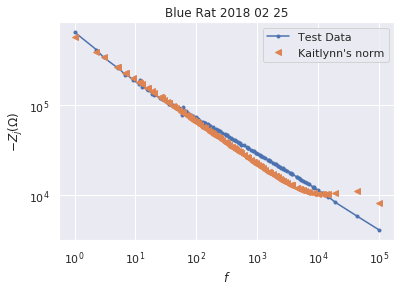

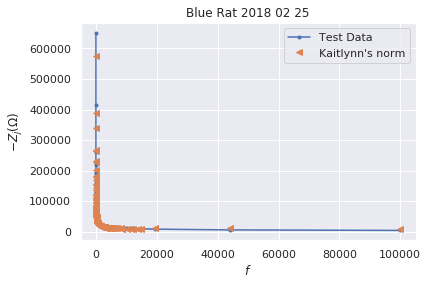

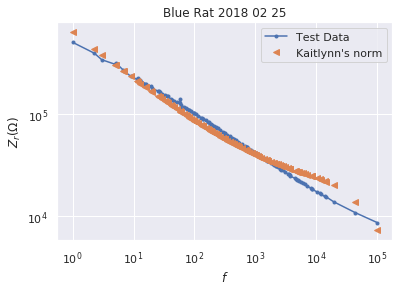

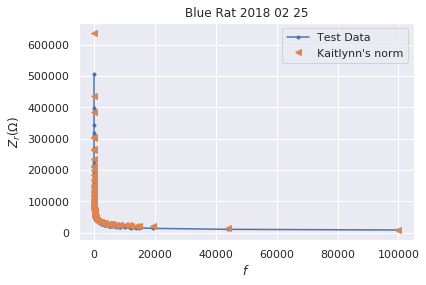

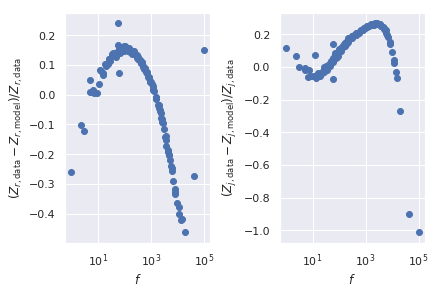

In [4]:
# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

# plot Kaitlynn's norm results
dataset = pd.read_csv(data_prefix+data_list[0])
j = 0*3
f = dataset.values[:, j]
n = len(f)
zr = dataset.values[:, j+1]
zj = dataset.values[:, j+2]
zr_lk, zj_lk = otto_model_create_data(res_lk2[0, :5])
title = 'Blue Rat 2018 02 25'
plt.figure()
plt.title(title)
plt.plot(zr, zj, '.-', label='Test Data')
plt.plot(zr_lk, zj_lk, '<', label="Kaitlynn's norm")

plt.xlabel(r'$Z_r (\Omega)$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('figs/' + title + 'logrj.png', dpi=300, bbox_inches='tight')


plt.figure()
plt.title(title)
plt.plot(zr, zj, '.-', label='Test Data')
plt.plot(zr_lk, zj_lk, '<', label="Kaitlynn's norm")

plt.xlabel(r'$Z_r (\Omega)$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.legend()
plt.savefig('figs/' + title + 'rj.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zj, '.-', label='Test Data')
plt.plot(f, zj_lk, '<', label="Kaitlynn's norm")
plt.xlabel(r'$f$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('figs/' + title + 'logj.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zj, '.-', label='Test Data')
plt.plot(f, zj_lk, '<', label="Kaitlynn's norm")
plt.xlabel(r'$f$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.legend()
plt.savefig('figs/' + title + 'j.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zr, '.-', label='Test Data')
plt.plot(f, zr_lk, '<', label="Kaitlynn's norm")
plt.xlabel(r'$f$')
plt.ylabel(r'$Z_r (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('figs/' + title + 'logr.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zr, '.-', label='Test Data')
plt.plot(f, zr_lk, '<', label="Kaitlynn's norm")
plt.xlabel(r'$f$')
plt.ylabel(r'$Z_r (\Omega)$')
plt.legend()
plt.savefig('figs/' + title + 'r.png', dpi=300, bbox_inches='tight')
plt.show()

# new plots based on Kaitlynn's suggestion
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(f, (zr-zr_lk)/zr, 'o')
ax[0].set_xscale('log')
ax[0].set_xlabel('$f$')
ax[0].set_ylabel(r'$(Z_{r,\mathrm{data}} - Z_{r,\mathrm{model}})/Z_{r,\mathrm{data}}$')

ax[1].plot(f, (zj-zj_lk)/zj, 'o')
ax[1].set_xscale('log')
ax[1].set_xlabel('$f$')
ax[1].set_ylabel(r'$(Z_{j,\mathrm{data}} - Z_{j,\mathrm{model}})/Z_{j,\mathrm{data}}$')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [5]:
columns = ['alpha CPE phase factor','K CPE magnitude factor', 'ren encapsulation resistance (k ohm)', 'rex extracellular resistance (k ohm)', 'am membrane area in cm**2', 'objective value']
index_rows = ['blue rat 2018_02_25 rep 1', 'blue rat 2018_02_25 rep 2', 'blue rat 2018_02_26 rep 1', 'blue rat 2018_02_26 rep 2', 'blue rat 2018_02_27 rep 1', 'blue rat 2018_02_27 rep 2',
             'blue rat 2018_03_03 rep 1', 'blue rat 2018_03_03 rep 2', 'blue rat 2018_03_10 rep 1', 'blue rat 2018_03_10 rep 2']
pd_l1 = pd.DataFrame(res_l1, index=index_rows, columns=columns)
pd_l2 = pd.DataFrame(res_l2, index=index_rows, columns=columns)
pd_lk1 = pd.DataFrame(res_lk1, index=index_rows, columns=columns)
pd_lk2 = pd.DataFrame(res_lk2, index=index_rows, columns=columns)

# Log10 L1 Norm

In [6]:
pd_l1

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance (k ohm),rex extracellular resistance (k ohm),am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.396616,0.632998,1.614965,1.000000e-04,1.000000e-10,0.018346
blue rat 2018_02_25 rep 2,0.392054,0.638047,1.917781,1.000000e-04,1.000000e-10,0.016790
blue rat 2018_02_26 rep 1,0.433004,0.551412,13.014576,1.000000e+30,1.281592e-03,0.069971
blue rat 2018_02_26 rep 2,0.433004,0.551412,13.014576,9.148862e+29,1.281592e-03,0.069971
blue rat 2018_02_27 rep 1,0.690864,0.008792,0.010000,1.000000e+30,1.146738e-04,0.177254
blue rat 2018_02_27 rep 2,0.702396,0.008016,0.010000,4.464065e+28,1.053588e-04,0.187103
blue rat 2018_03_03 rep 1,0.707649,0.006716,0.010000,1.000000e+30,2.991639e-04,0.167627
blue rat 2018_03_03 rep 2,0.703552,0.006949,0.010000,1.000000e+30,2.890038e-04,0.170187
blue rat 2018_03_10 rep 1,0.494893,0.045251,0.010000,1.000000e+30,7.591931e-04,0.094580
blue rat 2018_03_10 rep 2,0.493080,0.046723,0.010000,1.000000e+30,6.267885e-04,0.104558


# Log10 L2 Norm

In [7]:
pd_l2

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance (k ohm),rex extracellular resistance (k ohm),am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.404317,0.607213,2.569969,1.000000e-04,1.005011e-10,0.027266
blue rat 2018_02_25 rep 2,0.400002,0.610435,2.720185,4.987811e+29,3.822405e-02,0.029523
blue rat 2018_02_26 rep 1,0.482230,0.391945,12.183190,5.140182e+29,6.375094e-04,0.113650
blue rat 2018_02_26 rep 2,0.482230,0.391945,12.183190,1.000000e+30,6.375094e-04,0.113650
blue rat 2018_02_27 rep 1,0.584867,0.019532,0.010000,1.000000e+30,2.935164e-04,0.220694
blue rat 2018_02_27 rep 2,0.563280,0.022674,0.010000,1.000000e+30,4.616357e-04,0.240979
blue rat 2018_03_03 rep 1,0.737311,0.005658,0.010000,1.000000e+30,2.338739e-04,0.243488
blue rat 2018_03_03 rep 2,0.715553,0.006334,0.010000,2.436166e+29,3.031650e-04,0.212324
blue rat 2018_03_10 rep 1,0.512504,0.037334,0.010000,7.188957e+29,1.000000e+03,0.117963
blue rat 2018_03_10 rep 2,0.507193,0.039591,0.010000,1.000000e+30,1.807464e-02,0.123435


# L1 Kaitlynn's Norm

In [8]:
pd_lk1

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance (k ohm),rex extracellular resistance (k ohm),am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.395823,0.636240,1.534813,1.000000e-04,1.000000e-10,0.028419
blue rat 2018_02_25 rep 2,0.391129,0.642554,1.841519,1.000000e-04,1.000000e-10,0.025868
blue rat 2018_02_26 rep 1,0.427023,0.575185,13.413112,1.000000e+30,1.537536e-03,0.089234
blue rat 2018_02_26 rep 2,0.427023,0.575185,13.413112,3.181537e+29,1.537536e-03,0.089234
blue rat 2018_02_27 rep 1,0.613965,0.016483,0.010000,3.150482e+29,1.825188e-04,0.318932
blue rat 2018_02_27 rep 2,0.630654,0.014162,0.010000,3.230589e+29,1.637470e-04,0.318082
blue rat 2018_03_03 rep 1,0.510242,0.049629,0.010000,1.000000e-04,1.000000e+03,0.756481
blue rat 2018_03_03 rep 2,0.560796,0.027274,0.010000,1.000000e-04,1.000000e+03,0.648208
blue rat 2018_03_10 rep 1,0.492460,0.046208,0.010000,7.841340e+29,1.043910e-03,0.145939
blue rat 2018_03_10 rep 2,0.500801,0.044559,0.010000,3.890864e+29,5.182223e-04,0.161236


# L2 Kaitlynn's (original) norm

In [9]:
pd_lk2

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance (k ohm),rex extracellular resistance (k ohm),am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.475517,0.493267,1.966428,2.784163e+29,0.000452,1.214855e+09
blue rat 2018_02_25 rep 2,0.489460,0.469244,1.505356,7.441824e+29,0.000354,2.286670e+09
blue rat 2018_02_26 rep 1,0.529346,0.294484,10.347271,1.000000e+30,0.000263,7.572955e+11
blue rat 2018_02_26 rep 2,0.529346,0.294484,10.347252,4.022538e+29,0.000263,7.572955e+11
blue rat 2018_02_27 rep 1,0.347958,0.086732,0.010000,1.000000e-04,1000.000000,1.070544e+14
blue rat 2018_02_27 rep 2,0.363908,0.069511,0.010000,1.000000e-04,1000.000000,1.557607e+14
blue rat 2018_03_03 rep 1,0.358654,0.587792,0.010000,1.000000e-04,1000.000000,2.115058e+15
blue rat 2018_03_03 rep 2,0.266860,0.343785,0.010000,1.000000e-04,1000.000000,1.464283e+15
blue rat 2018_03_10 rep 1,0.543013,0.029015,0.010000,7.267450e+29,0.000887,1.437739e+11
blue rat 2018_03_10 rep 2,0.495729,0.039073,0.010000,1.000000e-04,1000.000000,3.621227e+11


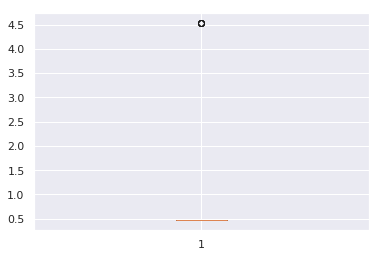

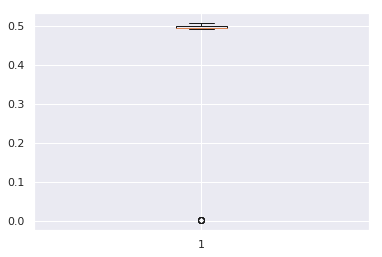

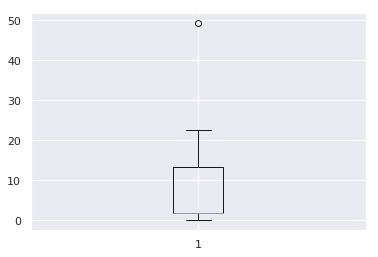

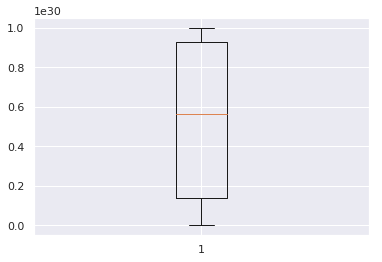

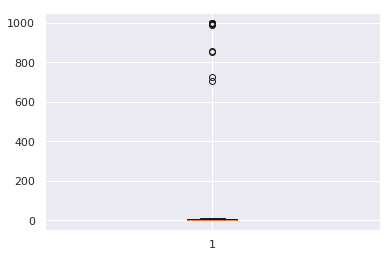

In [10]:
for i in range(5):
    plt.figure()
    plt.boxplot(lk2_params[0][:,i])
